In [ ]:
import numpy as np
import pandas as pd

from math import exp
from numpy import matmul as mul

from copy import deepcopy

import pickle

In [ ]:
def one_hot_encoding(y):
    '''
    Input parameters --->
    y = 1D numpy array having continuous integer values starting from 0
    
    Returns --->
    2D numpy array after implementing one-hot-encoding on y
    '''
    n_values = np.max(y) + 1
    
    return np.eye(n_values)[y]


    

In [ ]:
class MLPClassifier():
    """
    My implementation of a Neural Network Classifier.
    """

    acti_fns = ['relu', 'sigmoid', 'linear', 'tanh', 'softmax']
    weight_inits = ['zero', 'random', 'he', 'xavier']
    optimizer_fns = ['gradient_descent', 'gradient_descent_with_momentum', 'NAG', 'AdaGrad', 'RMSProp', 'Adam']
    Regularization_fns = ['l1', 'l2']
    
    # setting parameters that will be use in the class
    n_layers = None
    layer_sizes = None
    activation = None
    learning_rate = None
    weight_init = None
    batch_size = None
    num_epochs = None
    last_layer_activation = None
    optimizer = None
    regularizer = None
    kwargs = None
    dropouts = 0
    
    # weights = dictionary having keys like "W_1_2", which means weights between 1st and 2nd layer
    # i.e weights["W_1_2"] = num_of_nodes_layer_2 * num_of_nodes_layer_2 size
    weights = {}

    # optimizer_helper dic allows us to save the parameters 
    # which are necessary for opimizers like Adam, RMSProp, AdaGrad, etc
    optimizer_helper = {}
    
    # A dictionary and Z dictionary
    Z = {}     # Z[2] denotes the values of layer 2 before activation function (Z[1] = input features)
    A = {}     # A[1] denotes the values of layer 1 after activation function
    
    # for saving cost 
    training_cost_vs_iteration = []
    testing_cost_vs_iteration = []
    testing_accuracy = []
    training_accuracy = []
    

    def __init__(self, layers, learning_rate = 10**-5, activation_function = 'relu', optimizer = 'gradient_descent' , weight_init = 'random', regularization = 'l2', batch_size = 64, num_epochs = 100, dropouts = 0, **kwargs):
        """
        Initializing a new MyNeuralNetwork object

        Parameters
        ----------

        layers : integer array of size n_layers specifying the number of nodes in each layer

        activation_function : string specifying the activation function to be used
                              possible inputs: relu, sigmoid, linear, tanh

        learning_rate : float value specifying the learning rate to be used

        weight_init : string specifying the weight initialization function to be used
                      possible inputs: zero, random, normal

        batch_size : int value specifying the batch size to be used

        num_epochs : int value specifying the number of epochs to be used
        """

        if activation_function not in self.acti_fns:
            raise Exception('Incorrect Activation Function')

        if weight_init not in self.weight_inits:
            raise Exception('Incorrect Weight Initialization Function')
          
        if optimizer not in self.optimizer_fns:
            raise Exception('Incorrect Optimizer')
        
        if regularization not in self.Regularization_fns:
            raise Exception('Incorrect regularization')
        
        # setting model parameters
        self.n_layers = len(layers)
        self.layer_sizes = layers
        self.activation = activation_function
        self.learning_rate = learning_rate
        self.weight_init = weight_init
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.optimizer = optimizer
        self.dropouts = dropouts
        self.regularizer = regularization
        self.kwargs = kwargs
        self.last_layer_activation = 'softmax'
        
        self.weights = {}
        self.optimizer_helper = {}
        self.Z = {}
        self.A = {}
        
        self.training_cost_vs_iteration = []
        self.testing_cost_vs_iteration = []

        self.testing_accuracy = []
        self.training_accuracy = []
        
    
    def initialize_parameters(self):
        """
        Initialize parameters like weights{}, etc. 
        which are necessary before fitting the model
        """
        self.weights = {}
        self.Z = {}
        self.A = {}
        
        self.training_cost_vs_iteration = []
        self.testing_cost_vs_iteration = []
        
        n_layers = self.n_layers
        layer_sizes = self.layer_sizes
        
        # initializing weights dictionary
        for layer_no in range(1, n_layers):
            key = "W_" + str(layer_no) + "_" + str(layer_no+1)
            shape = tuple([layer_sizes[layer_no-1], layer_sizes[layer_no]])
            
            self.weights[key] = self.get_init_matrix(shape)
        
        
        # initializing some other thing (if u want) here in future  ...
        self.training_cost_vs_iteration = []
        self.testing_cost_vs_iteration = []

        self.testing_accuracy = []
        self.training_accuracy = []

        # initializing optimizer_helper
        self.initialize_optimizer_helper()
    

    def initialize_optimizer_helper(self):
        """
        Since we need a similiar dictionary of 2D numpy array (like weights)
        representing momentum, E (in case of RMSProp),  v (in case of Adam), etc

        So, this function initializes that for the given optimizer 

        Example - 
        otimizer_helper['m'] gives a dic with momentum corresponding to the weights dic with same keys
        otimizer_helper['E'] gives a dic with E corresponding to the weights dic with same keys (in case of RMSProp)

        etc etc etc ...
        """
        layer_sizes, n_layers = self.layer_sizes, self.n_layers
        optimizer_helper = self.optimizer_helper

        if (self.optimizer == 'gradient_descent_with_momentum' or self.optimizer == 'NAG'):
            optimizer_helper['M'] = {}

            # initializing optimizer_helper['E'] 
            for layer_no in range(1, n_layers):
                key = "W_" + str(layer_no) + "_" + str(layer_no+1)
                shape = tuple([layer_sizes[layer_no-1], layer_sizes[layer_no]])

                optimizer_helper['M'][key] = self.zero_init(shape)
            
        elif (self.optimizer == 'RMSProp'):
            optimizer_helper['E'] = {}

            # initializing optimizer_helper['E'] 
            for layer_no in range(1, n_layers):
                key = "W_" + str(layer_no) + "_" + str(layer_no+1)
                shape = tuple([layer_sizes[layer_no-1], layer_sizes[layer_no]])

                optimizer_helper['E'][key] = self.zero_init(shape)

        elif (self.optimizer == 'AdaGrad'):
            optimizer_helper['G'] = {}

            # initializing optimizer_helper['E'] 
            for layer_no in range(1, n_layers):
                key = "W_" + str(layer_no) + "_" + str(layer_no+1)
                shape = tuple([layer_sizes[layer_no-1], layer_sizes[layer_no]])

                optimizer_helper['G'][key] = self.zero_init(shape)


        elif (self.optimizer == 'Adam'):
            optimizer_helper['M']  = {} 
            optimizer_helper['V']  = {}

            # initializing optimizer_helper['E'] 
            for layer_no in range(1, n_layers):
                key = "W_" + str(layer_no) + "_" + str(layer_no+1)
                shape = tuple([layer_sizes[layer_no-1], layer_sizes[layer_no]])

                optimizer_helper['M'][key] = self.zero_init(shape)
                optimizer_helper['V'][key] = self.zero_init(shape)
            
        

    def relu(self, X):
        """
        Calculating the ReLU activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        return X * (X > 0)

    def relu_grad(self, X):
        """
        Calculating the gradient of ReLU activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        
        return 1. * (X > 0)

    def sigmoid(self, X):
        """
        Calculating the Sigmoid activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        return 1 / (1 + np.exp(-X))

    def sigmoid_grad(self, X):
        """
        Calculating the gradient of Sigmoid activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        
        sigmoid = 1 / (1 + np.exp(-X))
        
        return sigmoid * (1 - sigmoid)

    def linear(self, X):
        """
        Calculating the Linear activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        
        return np.clip(X, -10**5, 10**5)

    def linear_grad(self, X):
        """
        Calculating the gradient of Linear activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        
        return np.ones(len(X))

    def tanh(self, X):
        """
        Calculating the Tanh activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        # tanh = (np.exp(X) - np.exp(1-X)) / (np.exp(X) + np.exp(1-X))
        # the above tanh is slow, that's why using np.tanh
        return np.tanh(X)

    def tanh_grad(self, X):
        """
        Calculating the gradient of Tanh activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        # tanh = (np.exp(X) - np.exp(1-X)) / (np.exp(X) + np.exp(1-X))
        # the above tanh is slow, that's why using np.tanh
        
        tanh = np.tanh(X)
        
        return 1 - (tanh**2)

    def softmax(self, X):
        """
        Calculating the softmax activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        
        exps = np.exp(X - X.max())   # to avoid infinity
        return exps / np.sum(exps)

    def softmax_grad(self, X):
        """
        Calculating the gradient of Softmax activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        exps = np.exp(X - X.max())   # to avoid infinity
        
        softmax = exps / np.sum(exps)
        
        return softmax * (1 - softmax)
    
    def return_after_activation(self, X):
        """
        Apply the appropriate activation function as per the self.activation
        
        Parameters
        ----------
        X : 1-dimentional numpy array 
        
        Returns
        -------
        x_calc : 1-dimensional numpy array after applying the necessary activation function over X
        """
        
        if self.activation == 'relu':
            return self.relu(X)
        elif self.activation == 'sigmoid':
            return self.sigmoid(X)
        elif self.activation == 'linear':
            return self.linear(X)
        elif self.activation == 'tanh':
            return self.tanh(X)
        elif self.activation == 'softmax':
            return self.softmax(X)
    
    def return_after_last_layer_activation(self, X):
        """
        Apply the appropriate activation function as per the self.last_layer_activation
        
        Parameters
        ----------
        X : 1-dimentional numpy array 
        
        Returns
        -------
        x_calc : 1-dimensional numpy array after applying the necessary last_layer_activation function over X
        """
        
        if self.last_layer_activation == 'relu':
            return self.relu(X)
        elif self.last_layer_activation == 'sigmoid':
            return self.sigmoid(X)
        elif self.last_layer_activation == 'linear':
            return self.linear(X)
        elif self.last_layer_activation == 'tanh':
            return self.tanh(X)
        elif self.last_layer_activation == 'softmax':
            return self.softmax(X)
    
    def return_activation_grad(self, X):
        """
        Apply the appropriate activation_grad function as per the self.activation
        
        Parameters
        ----------
        X : 1-dimentional numpy array 
        
        Returns
        -------
        x_calc : 1-dimensional numpy array after applying the necessary activation_grad function over X
        """
        
        if self.activation == 'relu':
            return self.relu_grad(X)
        
        elif self.activation == 'sigmoid':
            return self.sigmoid_grad(X)
        
        elif self.activation == 'linear':
            return self.linear_grad(X)
        
        elif self.activation == 'tanh':
            return self.tanh_grad(X)
        
        elif self.activation == 'softmax':
            return self.softmax_grad(X)
        

    def zero_init(self, shape):
        """
        Calculating the initial weights after Zero Activation for a particular layer

        Parameters
        ----------
        shape : tuple specifying the shape of the layer for which weights have to be generated 

        Returns
        -------
        weight : 2-dimensional numpy array which contains the initial weights for the requested layer
        """
        shape_reverse = tuple([shape[1], shape[0]])
        matrix = np.zeros(shape_reverse)

        # now adding the bias weight as the first column
        # i.e. adding column of 0 at the start
        new_col = [0]*len(matrix)
        matrix = np.insert(matrix, 0, new_col, axis=1)

        return matrix

    def random_init(self, shape):
        """
        Calculating the initial weights after Random Activation for a particular layer

        Parameters
        ----------
        shape : tuple specifying the shape of the layer for which weights have to be generated 

        Returns
        -------
        weight : 1-dimensional numpy array which contains the initial weights for the requested layer
        """
        # NOTE :- np.random.rand gives values between 0 to 1 by normal distribution
        matrix = np.random.normal( size=(shape[1], shape[0]) )  *0.01

        # now adding the bias weight as the first column
        # i.e. adding column of 0 at the start
        new_col = [0]*len(matrix)
        matrix = np.insert(matrix, 0, new_col, axis=1)

        return matrix

    def he_init(self, shape):
        """
        Calculating the initial weights after He Activation for a particular layer
        Note --> Good for relu activation function

        Parameters
        ----------
        shape : tuple specifying the shape of the layer for which weights have to be generated 

        Returns
        -------
        weight : 1-dimensional numpy array which contains the initial weights for the requested layer
        """
        
        # NOTE :- np.random.rand gives values between 0 to 1 by normal distribution
        matrix = np.random.randn( shape[1], shape[0] )  * np.sqrt(2/shape[0])

        # now adding the bias weight as the first column
        # i.e. adding column of 0 at the start
        new_col = [0]*len(matrix)
        matrix = np.insert(matrix, 0, new_col, axis=1)

        return matrix
    
    def xavier_init(self, shape):
        """
        Calculating the initial weights after Xavier Activation for a particular layer

        Parameters
        ----------
        shape : tuple specifying the shape of the layer for which weights have to be generated 

        Returns
        -------
        weight : 1-dimensional numpy array which contains the initial weights for the requested layer
        """
        
        matrix = np.random.randn( shape[1], shape[0] )  * np.sqrt(1/shape[0])
        new_col = [0]*len(matrix)
        matrix = np.insert(matrix, 0, new_col, axis=1)

        return matrix           

    
    def get_init_matrix(self, shape):
        """
        returns the initialized weights matrix as per self.weight_init

        Parameters
        ----------
        shape : tuple specifying the shape of the layer for which weights have to be generated 

        Returns
        -------
        weight : 1-dimensional numpy array which contains the initial weights for the requested layer
        """
        
        if self.weight_init == 'zero':
            weight_matrix = self.zero_init(shape)
        
        elif self.weight_init == 'random':
            weight_matrix = self.random_init(shape)

        elif self.weight_init == 'he':
            weight_matrix = self.he_init(shape)

        elif self.weight_init == 'xavier':
            weight_matrix = self.xavier_init(shape)
        
        return weight_matrix

    def get_weights_power_sum(self, power = 1):
        '''
        Return the Σ(weights^power) in the model (used in L1 and L2 regularization)
        '''
        summ = 0

        for l in range(1, self.n_layers):
            # means if n_layers = 5, l goes from 4 to 1 (both included)
            key = "W_" + str(l) + "_" + str(l+1)
            summ += np.sum(self.weights[key] ** power)
        
        return summ
    
    
    def get_entropy_cost(self, Y_true, Y_predicted):
        '''
        Parameters
        ----------
        Y_true : 2D numpy array where each row represents the true label of each class (eg 1,0,0,0 or 0,0,1,0, etc)
        Y_pred : 2D numpy array where each row represents the predicted probability of each class (eg 0.4,0.6,0.3,1.... etc)
        '''
        
        # To remove 0 values, as log0 does NOT exists
        true = Y_true.flatten()
        pred = Y_predicted.flatten()
        
        # replacing 0 with 10**-10 to avoid error in log(pred)
        pred = np.where(pred==0, 10**-10, pred)
        
        # replacing 1 with 0.9999999 to avoid error in log(1-pred)
        pred = np.where(pred==1, 0.999999999, pred)
        
        left_half = true*np.log10(pred)
        right_half = (1-true)*np.log10(1 - pred)
        
        entropy = sum(-1 * left_half + right_half) / len(Y_true)

        # Now adding L1 or L2 regularization part
        lamda = self.kwargs['lamda'] if 'lamda' in kwargs else 0.01
        if (self.regularizer == 'l1'):
            weights_sum = self.get_weights_power_sum(power = 1)
            entropy += lamda * weights_sum / (2*len(Y_true))
        elif (self.regularizer == 'l2'):
            weights_square_sum = self.get_weights_power_sum(power = 2)
            entropy += lamda * weights_square_sum / (2*len(Y_true))

          
        return entropy
        
    def add_column_1_at_start(self, matrix):
        '''
        Simply add a column at start with all values as 1 and return it
        '''
        new_col = [1]*len(matrix)
        return np.insert(matrix, 0, new_col, axis=1)
        
        
    def forward_propogation(self, X_train, dropouts):
        '''
        Implementation of forward propogation, 
        and sets A dictionary and Z distionary accordingly
        '''
    
        for i in range(1, self.n_layers+1):
            if i == 1:
                # means 1st layer
                self.Z[1] = deepcopy(X_train)
                self.A[1] = deepcopy(self.Z[1])
                
                # i.e. adding column of 1 at the start
                self.A[1] = self.add_column_1_at_start(self.A[1])
                
            elif i == self.n_layers:
                # means last layer i.e last_layer_activation has to be applied
                w = self.weights["W_" + str(i-1) + "_" + str(i)]
                
                self.Z[i] = mul(self.A[i-1], w.T)
                self.A[i] = np.apply_along_axis(self.return_after_last_layer_activation, 1, self.Z[i])
                
                # i.e. last column 
                #      ==> no need to add column of 1 at the start
                
            else:
                # means hidden layers
                w = self.weights["W_" + str(i-1) + "_" + str(i)]
                
                self.Z[i] = mul(self.A[i-1], w.T)
                self.A[i] = np.apply_along_axis(self.return_after_activation, 1, self.Z[i])  # 1 means row-wise

                # now deactivating some neurons in layer i considering dropouts value
                keep_prob = 1 - dropouts
                d = np.random.rand(self.A[i].shape[1]) < keep_prob    # d = {True, False}^no_of_nodes_in_layer_i

                self.A[i] = self.A[i] * d
                self.A[i] /= keep_prob    # scaling so that expected value is same in training and testing
 
                # i.e. adding column of 1 at the start
                self.A[i] = self.add_column_1_at_start(self.A[i])
    
    
    def backward_propogation(self, Y_true, update_number):
        '''
        Updates the self.weights to reduce the cost function
        
        Parameters
        ----------
        Y_true : 2D numpy array where each row represents the true label of each class (eg 1,0,0,0 or 0,0,1,0, etc)
        Y_pred : 2D numpy array where each row represents the predicted Y after last layer cativation function
        '''
        # first calculating delta for each node of each layer (as defined by Andrew Ng)
        delta = {}   # keys like delta[3] = 2D numpy array denoting delta of 3rd layer nodes on all training data
        
        # Note : if a layer l has 5 nodes and input data has 10000 rows 
        #       ==> delta[l] = 10000*5 size 2D numpy array
        #       where [i][j] index represents delta for node j by i-th input row
        
        n_layers = self.n_layers
        layer_sizes = self.layer_sizes
        
        Y_predicted = self.A[n_layers]

        originial_weights = {}
        if self.optimizer == "NAG":
            # saving originial weights
            originial_weights = deepcopy(self.weights)

            # now doing weights = weights + beta*momentum
            # because loss differentiation has to be found from this new weights
            M = self.optimizer_helper['M']
            beta = self.kwargs['beta'] if 'beta' in self.kwargs else 0.9

            for key in self.weights:
                self.weights[key] += beta*M[key]

        
        for l in range(n_layers, 1, -1):
            if l == n_layers:
                # means last layer
                error = Y_predicted - Y_true
                delta[l] = error
            
            else:
                # mean hidden layers (because loop only goes to 2, as NO need to find delta of input layer)
                # claculating delta[l]
                w = self.weights[ "W_" + str(l) + "_" + str(l+1)]
                w_without_1st_col = w[:,1:]
                
                weighted_errors = mul(delta[l+1], w_without_1st_col)
                
                activation_gradient = np.apply_along_axis(self.return_activation_grad, 1, self.Z[l])
                
                delta[l] = activation_gradient * weighted_errors
        
        # now updating the weights dictionary
        for l in range(n_layers - 1, 0, -1):
            # means if n_layers = 5, l goes from 4 to 1 (both included)
            key = "W_" + str(l) + "_" + str(l+1)

            loss_differentiate = mul(self.A[l].T, delta[l+1]).T 

            # now adding regularizatio term to loss_differentiate
            lamda = self.kwargs['lamda'] if 'lamda' in kwargs else 0.01
            if (self.regularizer == 'l1'):
                loss_differentiate += lamda / (2*len(Y_true)) 
            elif (self.regularizer == 'l2'):
                loss_differentiate += ( lamda/(2*len(Y_true)) ) * self.weights[key]

            self.update_weights(key, loss_differentiate, update_number, originial_weights)
    
    def update_weights(self, key, loss_differentiate, update_number, originial_weights):
        """
        Update the weights of the given key i.e. update self.weights[key]
        
        Parameters
        ----------
        key : key (str) like in weights which tell us the weights on which we are working right now (eg - "W_2_3")
        loss_differentiate: 2D numpy array which represents delta_J wrt weight which we are updating
        update_number : Total No. of times a weight has been updated till now (i.e. no. of batches passed till now)
        originial_weights : in NAG, we need originial_weights, thus passing it here
        """
        if (self.optimizer == 'gradient_descent'):
            self.weights[key] -= self.learning_rate * loss_differentiate

        elif (self.optimizer == 'gradient_descent_with_momentum'):
            self.GD_momentum_weight_update(key, loss_differentiate) 

        elif (self.optimizer == 'RMSProp'):
            self.RMSProp_weight_update(key, loss_differentiate)

        elif (self.optimizer == 'NAG'):
            self.NAG_weight_update(key, loss_differentiate, originial_weights)

        elif (self.optimizer == 'AdaGrad'):
            self.AdaGrad_weight_update(key, loss_differentiate)
            
        elif (self.optimizer == 'Adam'):
            self.adam_weight_update(key, loss_differentiate, update_number)
            
    def GD_momentum_weight_update(self, key, loss_differentiate):
        """
        Update self.weights[key] considering Gradient descent with momentum as optimizer
        """  
        M = self.optimizer_helper['M']

        # getting parameters from kwargs
        kwargs = self.kwargs
        beta = kwargs['beta'] if 'beta' in kwargs else 0.9
        learning_rate = self.learning_rate
        
        # updating M
        M[key] = (beta*M[key]) - (learning_rate*loss_differentiate)

        # updating weights
        self.weights[key] += M[key]

    def NAG_weight_update(self, key, loss_differentiate, originial_weights):
        """
        Update self.weights[key] considering NAG as optimizer
        """  
        M = self.optimizer_helper['M']

        # getting parameters from kwargs
        kwargs = self.kwargs
        beta = kwargs['beta'] if 'beta' in kwargs else 0.9
        learning_rate = self.learning_rate
        
        # updating M
        M[key] = (beta*M[key]) - (learning_rate*loss_differentiate)

        # updating weights
        self.weights[key] = originial_weights[key] + M[key]

    def RMSProp_weight_update(self, key, loss_differentiate):
        """
        Update self.weights[key] considering RMSProp as optimizer
        """  
        E = self.optimizer_helper['E']

        # getting parameters from kwargs
        kwargs = self.kwargs
        gamma = kwargs['gamma'] if 'gamma' in kwargs else 0.9
        epsilon = kwargs['epsilon'] if 'epsilon' in kwargs else 10**-8
        learning_rate = self.learning_rate
        
        # updating E
        E[key] = (gamma*E[key]) + ((1-gamma)*np.square(loss_differentiate))

        # updating weights
        weights_to_add = loss_differentiate / np.sqrt(  E[key] + epsilon  )
        self.weights[key] -= self.learning_rate * weights_to_add
    
    
    def AdaGrad_weight_update(self, key, loss_differentiate):
        """
        Update self.weights[key] considering AdaGrad as optimizer
        """  
        G = self.optimizer_helper['G']

        # getting parameters from kwargs
        kwargs = self.kwargs
        epsilon = kwargs['epsilon'] if 'epsilon' in kwargs else 10**-8
        learning_rate = self.learning_rate

        # updating G
        G[key] += np.square(loss_differentiate)

        # updating weights
        weights_to_add = loss_differentiate / np.sqrt(  G[key] + epsilon  )
        self.weights[key] -= self.learning_rate * weights_to_add   

    def adam_weight_update(self, key, loss_differentiate, update_number):
        """
        Update self.weights[key] considering adam as optimizer
        """
        M = self.optimizer_helper['M']
        V = self.optimizer_helper['V']
        
        # getting parameters from kwargs
        kwargs = self.kwargs
        beta = kwargs['beta'] if 'beta' in kwargs else 0.9
        gamma = kwargs['gamma'] if 'gamma' in kwargs else 0.9
        epsilon = kwargs['epsilon'] if 'epsilon' in kwargs else 10**-8
        learning_rate = self.learning_rate
          
        # updating M and V
        M[key] =  (beta * M[key]) + ((1-beta)*loss_differentiate)
        V[key] = (gamma * V[key]) + ((1-gamma)*np.square(loss_differentiate))

        M[key] = M[key] / (1 - np.power(beta, update_number))    # bias correction
        V[key] = V[key] / (1 - np.power(gamma, update_number))   # bias correction

        # updating weights
        weights_to_add = M[key] / np.sqrt(  V[key] + epsilon  )
        self.weights[key] -= self.learning_rate * weights_to_add

    def fit(self, X, y, X_test = [], y_test = []):
        """
        Fitting (training) the linear model.

        Parameters
        ----------
        X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as training data.

        y : 1-dimensional numpy array of shape (n_samples,) which acts as training labels 
        (continuous integers form 0).
        
        X_test, y_test are only used for calculating testing cost after each iteration
        
        Returns
        -------
        self : an instance of self
        """
        
        self.initialize_parameters()
        
        encoded_y = one_hot_encoding(y)
        update_number = 0
        
        if (X_test != []):
            # means testing cost also has to be calculated
            y_test_encoded = one_hot_encoding(y_test)
        
        for i in range(self.num_epochs):
            # shuffling X and y in unison
            randomize = np.arange(len(X))
            np.random.shuffle(randomize)
            X = X[randomize]
            y = y[randomize]
            encoded_y = encoded_y[randomize]

            # doing mini-batch gradient descent
            start_index = 0  # denotes the start index of the present batch
            while (start_index < len(X)):
                # creating a batch
                if (start_index + self.batch_size < len(X)):
                    end_index = start_index + self.batch_size
                else:
                    end_index = len(X)
                
                update_number += 1

                batch_X = X[start_index : end_index,]
                batch_y = encoded_y[start_index : end_index,]
            
                self.forward_propogation(batch_X, dropouts = self.dropouts)
                #print("forward finished")
                
                self.backward_propogation(batch_y, update_number)
                #print("backward finished")
                
                start_index = end_index
            
            # calculating Entropy cost
            cost = self.get_entropy_cost(Y_true = encoded_y, Y_predicted = self.predict_proba(X))
            self.training_cost_vs_iteration.append(cost)
            print("Training cost at", i, "th iteration:", cost)
            
            # now printing the accuracy
            accuracy = self.score(X, y)
            print("Training Accuracy at", i, "th iteration:", accuracy)
            self.training_accuracy.append(accuracy)
            
            if (X_test != []):
                # calculating Entropy cost of testing data (only if given)
                cost = self.get_entropy_cost(Y_true = y_test_encoded, Y_predicted = self.predict_proba(X_test))
                self.testing_cost_vs_iteration.append(cost)
                print("Testing cost at", i, "th iteration:", cost)
                
                # now printing the accuracy
                accuracy = self.score(X_test, y_test)
                print("Testing Accuracy at", i, "th iteration:", accuracy)
                self.testing_accuracy.append(accuracy)
            
            print("-------------------------")


        # fit function has to return an instance of itself or else it won't work with test.py
        return self

    def predict_proba(self, X):
        """
        Predicting probabilities using the trained linear model.

        Parameters
        ----------
        X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as testing data.

        Returns
        -------
        y : 2-dimensional numpy array of shape (n_samples, n_classes) which contains the 
            class wise prediction probabilities.
        """
        
        # first fo forward propogation on X for setting A as required
        self.forward_propogation(X, dropouts = 0)
        
        # Y_predicted will be A of last layer
        Y_predicted = self.A[self.n_layers]

        # return the numpy array 
        return Y_predicted

    def predict(self, X):
        """
        Predicting values using the trained linear model.

        Parameters
        ----------
        X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as testing data.

        Returns
        -------
        y : 1-dimensional numpy array of shape (n_samples,) which contains the predicted values.
        """
        
        
        # first fo forward propogation on X for setting A as required
        self.forward_propogation(X, dropouts = 0)
        
        # Y_predicted will be A of last layer
        Y_predicted = self.A[self.n_layers]
        
        # return the numpy array  which contains the predicted values
        return np.argmax(Y_predicted, axis = 1)

    def score(self, X, y):
        """
        Returning accuracy using the trained linear model.

        Parameters
        ----------
        X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as testing data.

        y : 1-dimensional numpy array of shape (n_samples,) which acts as testing labels.

        Returns
        -------
        accuracy : float value specifying the accuracy of the model on the provided testing set (X, y)
        """
        Y_predicted = self.predict(X)
        correct_predictions = np.sum(Y_predicted == y)
        n_samples = len(Y_predicted)
        
        accuracy = (correct_predictions / n_samples)
        return accuracy
    
    def get_params(self):
        """
        Return An array of 2d numpy arrays. This array contains the weights of the model.
        """
        weights_array = []

        for l in range(1, self.n_layers):
            # means if n_layers = 5, l goes from 4 to 1 (both included)
            key = "W_" + str(l) + "_" + str(l+1)

            weights_array.append(self.weights[key])
        
        return weights_array








Importing train and val data

In [ ]:
def get_data(data_path):
    # reading the data
    filehandler = open(data_path , 'rb') 
    data_set = pickle.load(filehandler)

    y = np.array(list(data_set['Labels']))

    X = []
    for i in list(data_set['Image']):
        X.append(list(np.array(i).flatten()))
    
    X = np.array(X)

    return X.astype(np.int32), y.astype(np.int32)



In [ ]:
X_train, y_train = get_data('/content/drive/MyDrive/Deep learning/ass2/datasets/train_set.pkl')
X_test, y_test = get_data('/content/drive/MyDrive/Deep learning/ass2/datasets/val_set.pkl')

In [ ]:
y_test

array([7, 2, 1, ..., 0, 0, 0], dtype=int32)

function to Save model 

In [ ]:
def save_small_model(model_object, directory_to_save, model_name):
    """
    save the model_object at the path_to_save
    """

    # cleaning A and Z to reduce the size of the model
    n_layers = model_object.n_layers

    for i in range(1, n_layers+1):
        model_object.A[i] = []
        model_object.Z[i] = []
    
    # saving the small version of the model
    file_name = open(directory_to_save + model_name, 'wb') 
    pickle.dump(model_object, file_name)


Now running on the data

In [ ]:
acti_fns = ['relu', 'sigmoid', 'linear', 'tanh', 'softmax']
weight_inits = ['zero', 'random', 'he', 'xavier']
optimizer_fns = ['gradient_descent', 'gradient_descent_with_momentum', 'NAG', 'AdaGrad', 'RMSProp', 'Adam']
Regularization_fns = ['l1', 'l2',]


kwargs = {
    'beta' : 0.9,
    'gamma' : 0.9,
    'epsilon' : 10**-8,
    'lamda' : 0
}   

mnn = MLPClassifier(layers = [784, 256, 128, 64, 10], 
                    learning_rate = 0.001, 
                    activation_function = "tanh", 
                    optimizer = 'RMSProp',
                    weight_init = "xavier", 
                    regularization = 'l2',
                    batch_size = 64, 
                    num_epochs = 100,
                    dropouts = 0.2, 
                    **kwargs
                    )

In [ ]:
mnn.fit(X_train, y_train, X_test, y_test)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:868: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Training cost at 0 th iteration: 0.055672089160336814
Training Accuracy at 0 th iteration: 0.875
Testing cost at 0 th iteration: 0.07553265028352586


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:912: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Testing Accuracy at 0 th iteration: 0.8365
-------------------------
Training cost at 1 th iteration: 0.04694782126745832
Training Accuracy at 1 th iteration: 0.8979
Testing cost at 1 th iteration: 0.07265549330903776
Testing Accuracy at 1 th iteration: 0.8545
-------------------------
Training cost at 2 th iteration: 0.03868198994090765
Training Accuracy at 2 th iteration: 0.9048
Testing cost at 2 th iteration: 0.06544620190557698
Testing Accuracy at 2 th iteration: 0.855
-------------------------
Training cost at 3 th iteration: 0.032858152366459094
Training Accuracy at 3 th iteration: 0.9247
Testing cost at 3 th iteration: 0.06084757974697238
Testing Accuracy at 3 th iteration: 0.874
-------------------------
Training cost at 4 th iteration: 0.02890581689018674
Training Accuracy at 4 th iteration: 0.9277
Testing cost at 4 th iteration: 0.05022950030779396
Testing Accuracy at 4 th iteration: 0.884
-------------------------
Training cost at 5 th iteration: 0.0236882666989646
Training 

**`saving the model`**

In [ ]:
directory_to_save = "/content/drive/MyDrive/Deep learning/ass2/saved_models/part_2.2/"
model_name = "dropout_xavier_tanh_RMSprop.pickle"

# saving the model
save_small_model(mnn, directory_to_save, model_name)

In [ ]:
# reading the saved model
filehandler = open(directory_to_save + model_name, 'rb') 
mnnn = pickle.load(filehandler)


In [ ]:
mnnn.activation, mnnn.optimizer, mnnn.regularizer, mnn.weight_init

('tanh', 'RMSProp', 'l2', 'xavier')

# Analysis

**`Plotting graphs`**

In [ ]:
import matplotlib.pyplot as plt
def plot_graphs(mnn):
    training_cost_vs_iteration = mnn.training_cost_vs_iteration
    testing_cost_vs_iteration = mnn.testing_cost_vs_iteration
    testing_accuracy = mnn.testing_accuracy
    training_accuracy = mnn.training_accuracy

    activation, optimizer, regularizer, weight_init = mnn.activation, mnn.optimizer, mnn.regularizer, mnn.weight_init

    epochs = [i for i in range(1, len(training_cost_vs_iteration)+1, 1)]

    # cross entropy graph
    plt.plot(epochs, training_cost_vs_iteration, label = "Training Cross Entropy")
    plt.plot(epochs, testing_cost_vs_iteration, "--" , label = "Testing Cross Entropy")

    plt.legend()

    plt.ylabel('Cross Entropy')
    plt.xlabel('Epochs')

    plt.title("Cross entropy vs epochs (" + activation + ", " + optimizer + ", " + weight_init + ", " + regularizer + ")")
    plt.show()

    # accuracy graph
    plt.plot(epochs, training_accuracy, label = "Training  Accuracy")
    plt.plot(epochs, testing_accuracy, "--" , label = "Testing Accuracy")

    plt.legend()

    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')

    plt.title('Accuracy vs epochs (' + activation + ", " + optimizer + ", " + weight_init + ", " + regularizer + ")")
    plt.rcParams["figure.figsize"] = (7,5)
    plt.show()



In [ ]:
# reading the saved model
directory_to_save = "/content/drive/MyDrive/Deep learning/ass2/saved_models/part_2.2/"
model_name = "dropout_xavier_tanh_RMSprop.pickle"

filehandler = open(directory_to_save + model_name, 'rb') 

model = pickle.load(filehandler)

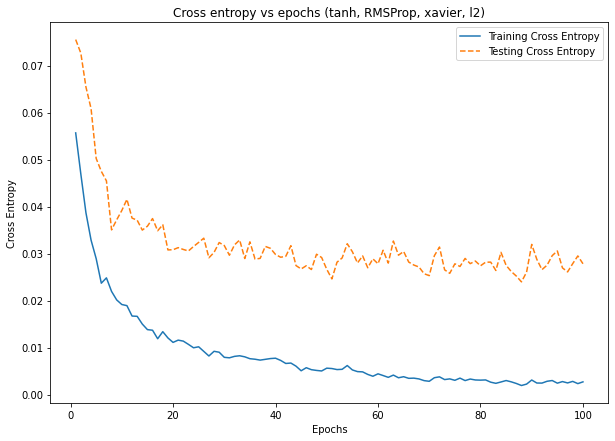

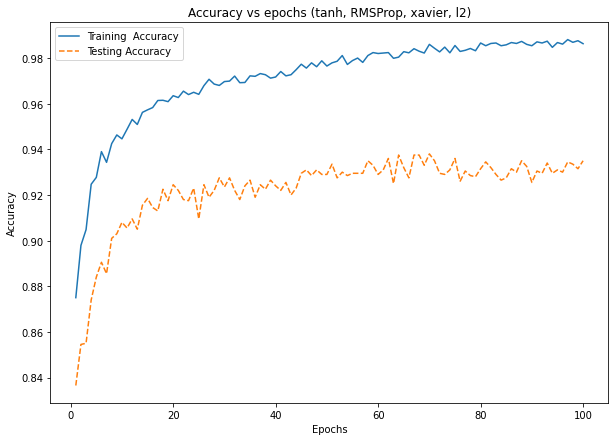

In [ ]:
plot_graphs(model)

**`Printing Accuracy`**

In [ ]:
print("Model details:", model.activation + ", " + model.optimizer + ", " + model.weight_init + ", " + model.regularizer )
print("Testing Accuracy :", model.testing_accuracy[-1])
print("Training Accuracy :", model.training_accuracy[-1])

Model details: tanh, RMSProp, xavier, l2
Testing Accuracy : 0.935
Training Accuracy : 0.9863


**`Confusion matrix`**

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

print("Confusion matrix of the Validation data\n")
y_true = list(y_test)
y_pred = list(model.predict(X_test))

confusion_matrix(y_true, y_pred)


Confusion matrix of the Validation data



array([[198,   0,   0,   0,   0,   0,   1,   0,   1,   0],
       [  0, 195,   1,   1,   0,   0,   1,   0,   2,   0],
       [  1,   0, 188,   1,   0,   0,   3,   3,   3,   1],
       [  0,   1,   0, 186,   0,   5,   0,   5,   2,   1],
       [  1,   0,   0,   0, 187,   0,   4,   1,   1,   6],
       [  2,   0,   1,   4,   3, 187,   0,   0,   2,   1],
       [  4,   2,   2,   0,   3,   3, 185,   0,   1,   0],
       [  0,   4,   4,   0,   1,   1,   0, 185,   0,   5],
       [  2,   2,   2,   4,   5,   3,   1,   1, 179,   1],
       [  0,   0,   0,   1,   9,   1,   0,   3,   6, 180]])

**`ROC Curve`**

In [ ]:
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


y_score = model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

encoded_y = one_hot_encoding(y_test)
n_classes = 10

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(encoded_y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(encoded_y.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  import sys


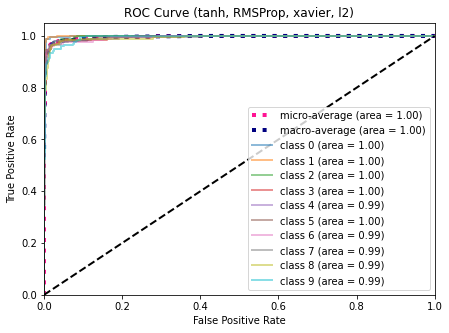

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i],alpha=0.5, lw=2,
             label='class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (' + model.activation + ", " + model.optimizer + ", " + model.weight_init + ", " + model.regularizer + ")")
plt.legend(loc="lower right")
plt.rcParams["figure.figsize"] = (10,7)
plt.show()